
#### Split images from `/data/defungi` folder into train, test and validation sets using  install [split-folders](https://pypi.org/project/split-folders/0.3.1/) library

The dataset comes in a single folder, with subfolders containing images of the classes. We split images in each class into train, validation and test sets.

In [2]:
! pip install split-folders tqdm

In [3]:
#Good old imports
import splitfolders
import os
import pandas as pd

#use  tf version 2.9.0 and up to import from utils
# from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import img_to_array, array_to_img, img_to_array, load_img, ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense



Below, we check the number of items in each folder.

In [4]:
#define path 
path = "data/defungi"

classes = os.listdir(path)
print(len(classes),"Folders Found")

for folder in classes:
  num_items = len(os.listdir(os.path.join(path, folder)))
  print(folder + ":", num_items, " items")


5 Folders Found
H1: 4404  items
H2: 2334  items
H3: 819  items
H5: 818  items
H6: 739  items


The code below does the splitting. Since we only needed this code to run once, it's now commented after the data was split.

In [5]:
# # Split with a ration of items for each set.
# splitfolders.ratio(path, output="data/split-defungi",
#     seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Below, we fing the number of items in each class' test, train and validation folders.

In [6]:
#preview the number of items in each split
for i, value in enumerate(classes):
    
    print(f"\nClass {value}: ")
    
    for folder in os.listdir("data/split-defungi"):
       
        print(folder, ":",len(os.listdir(os.path.join("data/split-defungi"+"/"+folder, classes[i]))))
        # values = {split:count for }


Class H1: 
test : 441
train : 3523
val : 440

Class H2: 
test : 234
train : 1867
val : 233

Class H3: 
test : 83
train : 655
val : 81

Class H5: 
test : 83
train : 654
val : 81

Class H6: 
test : 75
train : 591
val : 73


splits appear to have worked well. 

### Loading images using ImageDataGenerator

In [7]:
#preview some images from each class 
train_data_dir = 'data/split-defungi/train/'
val_data_dir  = 'data/split-defungi/val/'
test_data_dir = 'data/split-defungi/test/'

In [18]:
# Get all the data in the directory data/split-defungi/test/ and reshape them
print("\nTest...")

test_generator = ImageDataGenerator().flow_from_directory(test_data_dir, target_size=(500,500) , batch_size=916)

# Get all the data in the directory data/split-defungi/test/, and reshape them
print("\nTrain...")
train_generator = ImageDataGenerator().flow_from_directory(train_data_dir, target_size=(500,500), batch_size=900)

print("\nValidation...")
val_generator = ImageDataGenerator().flow_from_directory(val_data_dir, target_size=(500,500), batch_size=908)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(test_generator) 


Test...
Found 916 images belonging to 5 classes.

Train...
Found 7290 images belonging to 5 classes.

Validation...
Found 908 images belonging to 5 classes.


Below, we preview 2 images with their corresponding labels, just to confirm that our data is ready for modelling.

[1. 0. 0. 0. 0.]


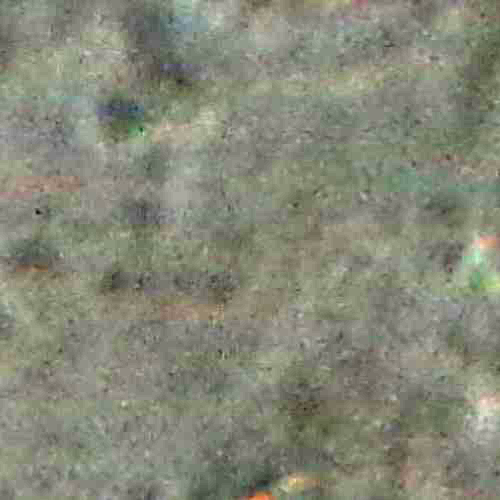

In [16]:
#preview an image or two
print(train_labels[0])
array_to_img((train_images[0]))


[0. 1. 0. 0. 0.]


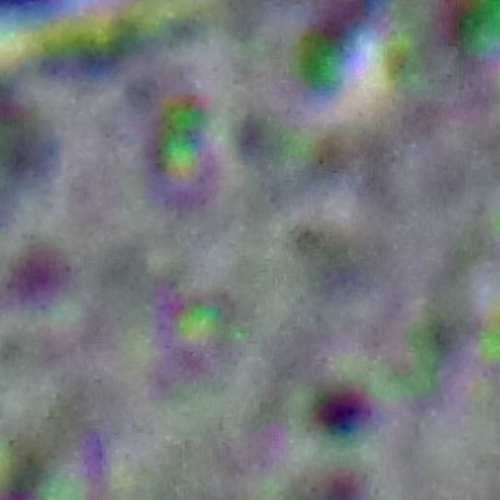

In [15]:
print(val_labels[8])
array_to_img((val_images[8]))

## Baseline Model: Multi-Layer Perceptron 

MLPs take inputs as vectors, and not matrices/tensors. Below, let's check the shape of our data

In [19]:
#check the shape of our input 
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

(900, 500, 500, 3)
(916, 500, 500, 3)
(916, 500, 500, 3)


_Interpretation:_
* For the batch we collected, each set contains the specfified number of items.
* Image dimensions are set to 500 x 500, according to the [source paper](https://arxiv.org/abs/2109.07322) 
* Each image is a color image with 3 dimensions (R,G,B)

To convert these tensors to vectors for use with our MLP, we'll flatten the 2nd, 3rd, and 4th dimensions to have a shape of (32, 500x500x3).

Many machine learning algorithms expect input data in the form of a 2D array, where each row represents a single sample and each column represents a feature.


In [21]:
#reshape the images so each will be a 1D vector
train_img = train_images.reshape(train_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)

In [22]:
# See shapes of reshaped inputs

print(train_img.shape)
print(val_img.shape)
print(test_img.shape)

(900, 750000)
(916, 750000)
(916, 750000)


For faster computation, let's normalize the images by dividing the pixel values by the max possible value (255)

In [23]:
train_img /=255.
val_img /=255.
test_img /=255.

Below, we build our first model. It's a multi-layer perceptron with:
* an input layer 
* one hidden layer
* an output layer with 5 nodes

In [49]:
#Build baseline model 1
model_1  = Sequential()
model_1.add(Dense(64, activation = 'tanh', input_shape = (500,500,3)))
model_1.add(Dense(32, activation = 'tanh'))
model_1.add(Dense(5, activation = 'softmax'))   

We compile the model using:


In [43]:
model_1.compile(loss = 'categorical_crossentropy',
               optimizer = 'sgd',
               metrics = ['acc']) 

In [44]:
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 500, 500, 64)      256       
_________________________________________________________________
dense_16 (Dense)             (None, 500, 500, 32)      2080      
_________________________________________________________________
dense_17 (Dense)             (None, 500, 500, 5)       165       
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
_________________________________________________________________


In [82]:
# Train the model
history = model_1.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [107]:
def visualize_training_results(results, epochs, model_name):
    plt.figure(figsize=(10,6))
    plt.plot (range(1,epochs), results.history['loss'], label = "Train Loss")
    plt.plot (range(1,epochs), results.history['val_loss'], label = "Validation Loss")
    plt.title(model_name+"Loss plot")
    plt.xlabel ("Number of epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,6))
    plt.plot (range(1,epochs), results.history['accuracy'], label = "Train Accuracy")
    plt.plot (range(1,epochs), results.history['val_accuracy'], label = "Validation Accuracy")
    plt.title(model_name+"Accuracy  plot")
    plt.xlabel ("Number of epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()     

In [70]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data paths
train_path = "data/split-defungi/train"
val_path = "data/split-defungi/val"
test_path = "data/split-defungi/test"

# Define image dimensions and batch size
img_width, img_height = 500, 500
batch_size = 32

# Create data generators with augmentation for the training set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_path,
                                                target_size=(img_width, img_height),
                                                batch_size=batch_size,
                                                class_mode='categorical')

test_generator = val_datagen.flow_from_directory(test_path,
                                                 target_size=(img_width, img_height),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

# Build the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))  # Assuming there are 5 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_steps=val_generator.samples // batch_size)




Found 7290 images belonging to 5 classes.
Found 908 images belonging to 5 classes.
Found 916 images belonging to 5 classes.
Epoch 1/10
227/227 [==============================] - 2315s 10s/step - loss: 1.4392 - accuracy: 0.5564 - val_loss: 1.0116 - val_accuracy: 0.5960
Epoch 2/10
227/227 [==============================] - 4948s 22s/step - loss: 1.0113 - accuracy: 0.5985 - val_loss: 0.9447 - val_accuracy: 0.6138
Epoch 3/10
227/227 [==============================] - 1538s 7s/step - loss: 0.9338 - accuracy: 0.6305 - val_loss: 0.9195 - val_accuracy: 0.6540
Epoch 4/10
227/227 [==============================] - 1796s 8s/step - loss: 0.9377 - accuracy: 0.6232 - val_loss: 0.9286 - val_accuracy: 0.6384
Epoch 5/10
227/227 [==============================] - 1548s 7s/step - loss: 0.9386 - accuracy: 0.6283 - val_loss: 0.9423 - val_accuracy: 0.6194
Epoch 6/10
139/227 [=================>............] - ETA: 9:31 - loss: 0.9121 - accuracy: 0.6538

KeyboardInterrupt: 

* First Convolutional Layer
32 Filters: Detect different patterns or features in the input image.\
Filter Size (3, 3): Determines the spatial extent of detected patterns.\
Activation Function ('relu'): Introduces non-linearity.
* Max Pooling Layer
Reduces spatial dimensions and parameters, ensuring translational invariance.
Second Convolutional Layer
64 Filters: Captures more complex features in deeper layers.
* Third Convolutional Layer
128 Filters: Learns more complex hierarchical features.
* Flatten Layer and Dense Layer
Flatten: Converts 2D matrix data to a vector.
Dense (128 nodes): Introduces capacity for learning high-level abstractions.
* Output Layer
Nodes match classes in the task (assuming 5 classes).
Softmax activation: Common for multi-class classification problems.

### CNN  model Results and interpretation 

In [73]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Accuracy: {test_acc}")

28/28 [==============================] - 50s 2s/step - loss: 0.9436 - accuracy: 0.6250
Test Accuracy: 0.625


Test Accuracy for our CNN model is 62.5% which isn't that badly off but not impressive either. We'll try using another model to try and get improved results.

## Model II - Transfer Learning with MobileNetV2 model 

By the point we're terminating the convolutional neural network above, the best accuracy we've hit is 65% on the train set and 61% on the validation set. \
Next, we'll use [MobileNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2), a pe-trained network to try and improve performance


The pre-trained MobileNetV2 is known for it efficiency and will be used as a feature extractor. We'll then add a few dense layers on top and freeze the weights of the pre-trained layers and only train the newly added dense layers.

In [77]:
from tensorflow.keras.applications import MobileNetV2


In [79]:
# Create MobileNetV2 base model with pre-trained weights
base_model = MobileNetV2(input_shape=(img_width, img_height, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the weights of the pre-trained layers
# Freezing the convolutional base before compiling and training the model 
# prevents the weigths in the base_model layer from being updated during training

for layer in base_model.layers:
    layer.trainable = False

# Build a new model on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Assuming there are 5 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_steps=val_generator.samples // batch_size)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Accuracy: {test_acc}")

Epoch 1/10
227/227 [==============================] - 977s 4s/step - loss: 0.9431 - accuracy: 0.6161 - val_loss: 0.8108 - val_accuracy: 0.6629
Epoch 2/10
227/227 [==============================] - 905s 4s/step - loss: 0.7953 - accuracy: 0.6746 - val_loss: 0.8016 - val_accuracy: 0.6763
Epoch 3/10
227/227 [==============================] - 904s 4s/step - loss: 0.7298 - accuracy: 0.7071 - val_loss: 0.7385 - val_accuracy: 0.7154
Epoch 4/10
227/227 [==============================] - 903s 4s/step - loss: 0.6901 - accuracy: 0.7229 - val_loss: 0.7148 - val_accuracy: 0.7176
Epoch 5/10
227/227 [==============================] - 903s 4s/step - loss: 0.6695 - accuracy: 0.7323 - val_loss: 0.7303 - val_accuracy: 0.7154
Epoch 6/10
227/227 [==============================] - 903s 4s/step - loss: 0.6598 - accuracy: 0.7357 - val_loss: 0.7138 - val_accuracy: 0.7321
Epoch 7/10
227/227 [==============================] - 904s 4s/step - loss: 0.6347 - accuracy: 0.7406 - val_loss: 0.6921 - val_accuracy: 0.7321

Test Accuracy for put second model improved significantly, hitting highs of 75% on the train set, 74% on the validation set and 71% on the test set.
Let's visualize the results:

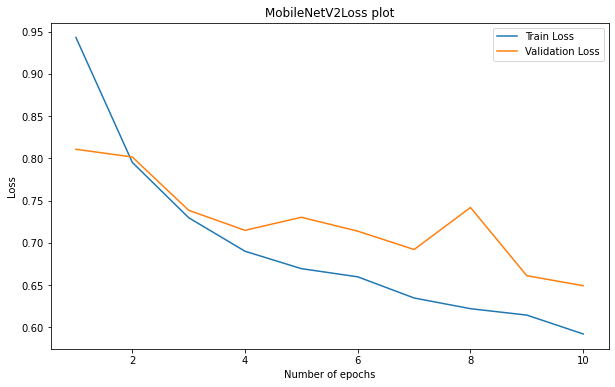

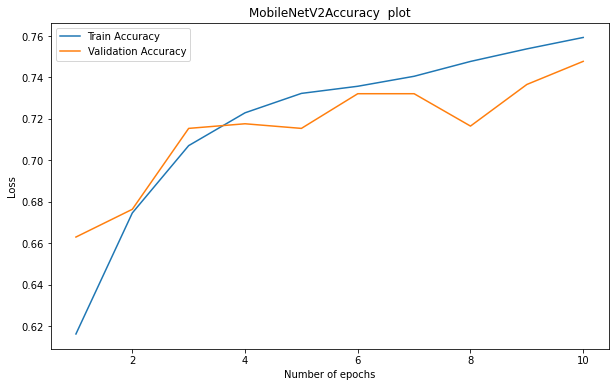

In [108]:

visualize_training_results(history, 11, 'MobileNetV2')

The model appears to be a significant improvement over our baseline MLP and the CNN. It's not overfitting and the accuracy seems to improve with the number of epochs

## Model 4: EfficientNetB0


One of the main challenges we're facing is the extremely long time it's taking to fit and eveluate these models, with our best now taking over 2 hours. Our next model, EfficientNetB0, attempts to help us with that.

The choice of the EfficientNetB0 model for our business case is justified by:
* its efficiency in resource usage, 
* strong transfer learning capabilities from pre-training on ImageNet,
* adaptability to varying image sizes,
* demonstrated high performance in image classification tasks, 
* reduced risk of overfitting through feature extraction, 
* balancing computational efficiency with robust classification capabilities.








In [115]:
from tensorflow.keras.applications import EfficientNetB0


In [116]:
# Create EfficientNetB0 base model with pre-trained weights


base_model = EfficientNetB0(
    input_shape=(img_width, img_height, 3),
                             include_top=False,
                             weights='imagenet'
)


# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Build a new model on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Assuming there are 5 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history_eff = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_steps=val_generator.samples // batch_size)


16711680/16705208 [==============================] - 3s 0us/step
Epoch 1/10
227/227 [==============================] - 2154s 9s/step - loss: 1.3541 - accuracy: 0.4820 - val_loss: 1.3409 - val_accuracy: 0.4866
Epoch 2/10
227/227 [==============================] - 1459s 6s/step - loss: 1.3455 - accuracy: 0.4833 - val_loss: 1.3492 - val_accuracy: 0.4821
Epoch 3/10
 25/227 [==>...........................] - ETA: 18:16 - loss: 1.3439 - accuracy: 0.4762

KeyboardInterrupt: 

1 hour and  2 epochs later, our model was showing signs of performing worse than MobileNetV2. We terminated the training to save time and try other models.

## Mdel 5: ResNet101

Resnets help us deal with the issue of vanishing gradients. When the network is too deep, the gradients from where the loss function is calculated easily shrink to zero after several applications of the chain rule. This result on the weights never updating its values and therefore, no learning is being performed.


In [117]:
from tensorflow.keras.applications import ResNet101


In [118]:
# Create ResNet101 base model with pre-trained weights
base_model = ResNet101(input_shape=(img_width, img_height, 3),
                       include_top=False,
                       weights='imagenet')

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Build a new model on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Assuming there are 5 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_steps=val_generator.samples // batch_size)



171450368/171446536 [==============================] - 23s 0us/step
Epoch 1/10
 57/227 [======>.......................] - ETA: 1:00:05 - loss: 1.4933 - accuracy: 0.4468

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Accuracy: {test_acc}")